In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import pickle
# from scipy.spatial.distance import cdist
from scipy.sparse import csr_matrix
from implicit.bpr import BayesianPersonalizedRanking
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import ItemItemRecommender, bm25_weight, tfidf_weight
from metrics import precision_at_k, recall_at_k
from utils import prefilter_items, reduce_dims, display_components_in_2D_space
from recommender import MainRecommender
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

%matplotlib inline

In [2]:
data = pd.read_csv('./data/transaction_data.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                     'product_id': 'item_id'},
            inplace=True)

test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(3)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.3,1631,1,0.0,0.0


In [3]:
item_features = pd.read_csv('./data/product.csv')
item_features.columns = [col.lower() for col in item_features.columns]
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)

item_features.head(3)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,


In [4]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(3)

,user_id,actual
0,1,"[879517, 934369, 1115576, 1124029, 5572301, 65..."
1,3,"[823704, 834117, 840244, 913785, 917816, 93870..."
2,5,"[913077, 1118028, 1386668]"


In [5]:
n_items_before = data_train['item_id'].nunique()

data_train = prefilter_items(data_train, item_features=item_features, take_n_popular=5000)

n_items_after = data_train['item_id'].nunique()

print(f'Decreased # items from {n_items_before} to {n_items_after}')

D:\courses\recommender_system\practice\utils.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))


Decreased # items from 90386 to 5001


In [6]:
recommender = MainRecommender(data_train)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

In [7]:
%%time
result['als_bm25'] = result['user_id'].apply(lambda x: recommender.get_recommendations(user=x, model=recommender.model))

print('Precision:', result.apply(lambda row: precision_at_k(row['als_bm25'], row['actual']), axis=1).mean())

Precision: 0.09713711702661937
Wall time: 7.78 s


In [8]:
result.head()

,user_id,actual,als_bm25
0,1,"[879517, 934369, 1115576, 1124029, 5572301, 65...","[6533936, 841584, 960732, 978343, 1082212]"
1,3,"[823704, 834117, 840244, 913785, 917816, 93870...","[1044078, 1106523, 8090521, 844179, 8090537]"
2,5,"[913077, 1118028, 1386668]","[1006483, 922636, 9707498, 969846, 957951]"
3,6,"[825541, 859676, 999318, 1055646, 1067606, 108...","[1026118, 1084036, 965267, 878996, 863632]"
4,7,"[929248, 948622, 1013572, 1022003, 1049892, 10...","[5981267, 1117556, 916487, 839419, 6533878]"


# Альтернативные способы предсказаний

## Кейс 1. Продажи товаров собственной торговой марки (СТМ)

In [9]:
item_features.head(3)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,


In [10]:
item_features = item_features[item_features['item_id'].isin(recommender.itemid_to_id.keys())]
item_features[item_features['brand'] == 'Private'].item_id.nunique()

791

In [11]:
own_items = item_features[item_features['brand'] == 'Private'].\
    groupby('department')['item_id'].nunique().\
    sort_values(ascending=False)

own_items

department
GROCERY          483
MEAT-PCKGD        94
DELI              48
DRUG GM           48
PASTRY            38
SEAFOOD-PCKGD     35
PRODUCE           23
NUTRITION         11
MEAT               9
FLORAL             2
Name: item_id, dtype: int64

In [12]:
categories_with_own_items = own_items.index.tolist()

In [13]:
recommender.model.item_factors.shape

(5001, 20)

In [14]:
category = []

for idx in range(recommender.model.item_factors.shape[0]):
    
    try:
        cat = item_features.loc[item_features['item_id'] == recommender.id_to_itemid[idx], 'department'].values[0]
        category.append(cat)
    except:
        category.append('UNKNOWN')

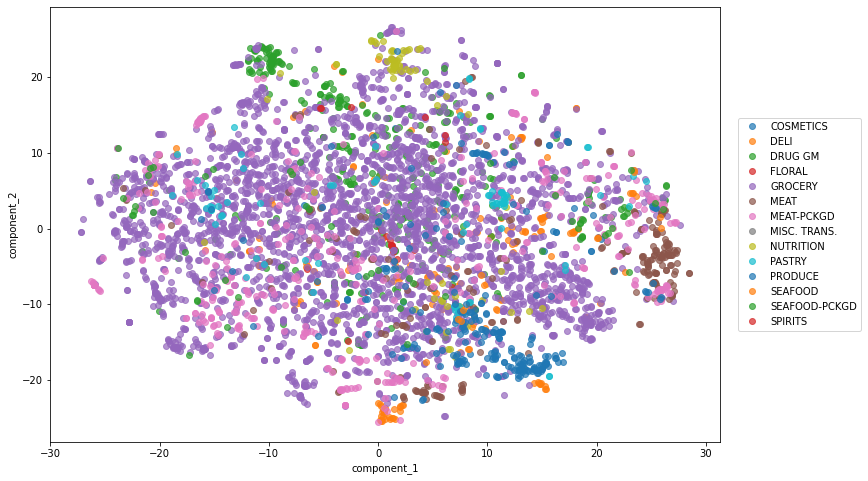

Wall time: 5.65 s


In [15]:
%%time
item_emb_tsne = reduce_dims(recommender.model.item_factors, dims=2, method='tsne')
item_emb_tsne['category'] = category
item_emb_tsne['item_id'] = list(recommender.itemid_to_id.keys())
item_emb_tsne = item_emb_tsne[item_emb_tsne['category'] != 'UNKNOWN']

display_components_in_2D_space(item_emb_tsne, labels='category')

In [16]:
item_emb_tsne_reduced = item_emb_tsne[item_emb_tsne['category'] != 'GROCERY']

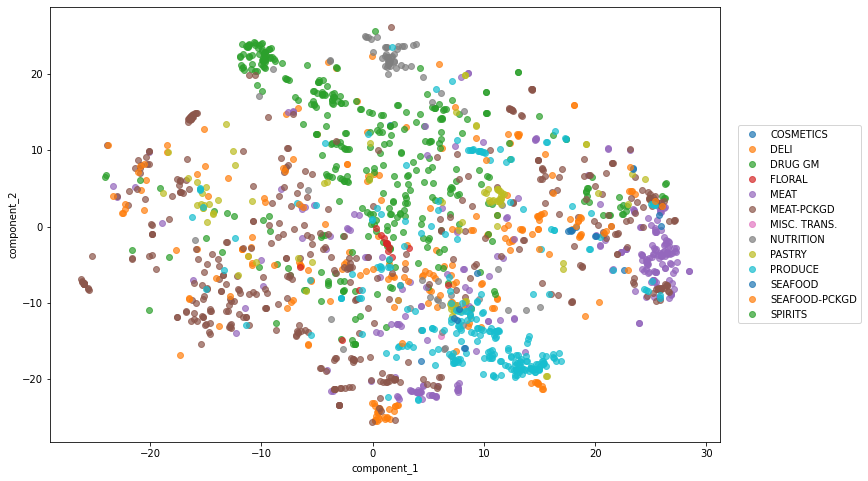

In [17]:
display_components_in_2D_space(item_emb_tsne_reduced, labels='category')

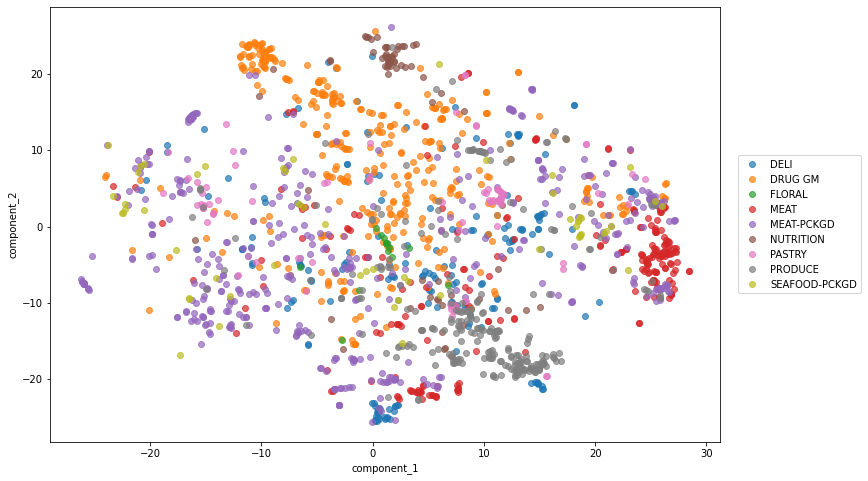

In [18]:
display_components_in_2D_space(item_emb_tsne_reduced[item_emb_tsne_reduced['category'].isin(categories_with_own_items)],
                               labels='category')

In [19]:
similar_items = recommender.model.similar_items(recommender.itemid_to_id[1004906], N=50)
similar_items = [recommender.id_to_itemid[sim[0]] for sim in similar_items]
similar_items.append(1004906)

In [20]:
item_emb_tsne[item_emb_tsne['item_id'] == 1004906]

,component_2,component_1,category,item_id
2089,-9.300195,25.812759,PRODUCE,1004906


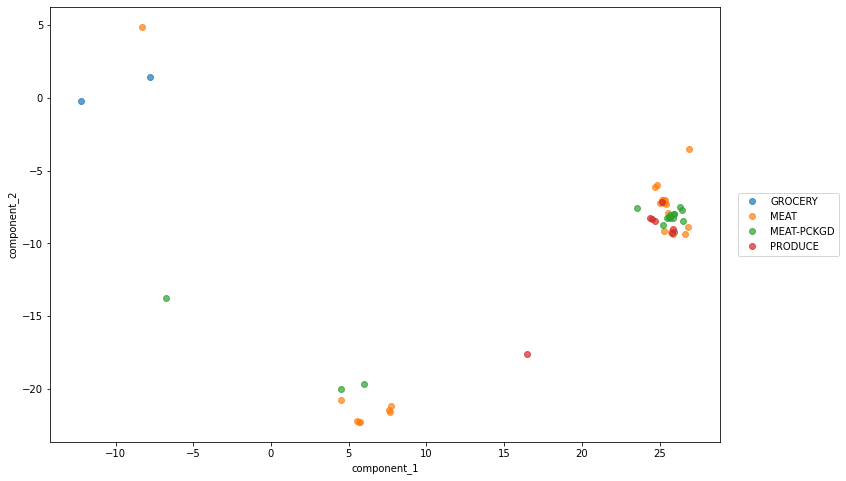

In [21]:
display_components_in_2D_space(item_emb_tsne[item_emb_tsne['item_id'].isin(similar_items)],
                               labels='category')

In [22]:
recommendation_similar_items = recommender.get_similar_items_recommendation()

In [23]:
result_predict = result.merge(recommendation_similar_items, on='user_id', how='inner')
result_predict.head()

,user_id,actual,als_bm25,similar_recommendation
0,1,"[879517, 934369, 1115576, 1124029, 5572301, 65...","[6533936, 841584, 960732, 978343, 1082212]","[824758, 1007512, 9297615, 9297461, 1014509]"
1,3,"[823704, 834117, 840244, 913785, 917816, 93870...","[1044078, 1106523, 8090521, 844179, 8090537]","[1044078, 1024051, 832678, 839419, 956399]"
2,5,"[913077, 1118028, 1386668]","[1006483, 922636, 9707498, 969846, 957951]","[12262778, 884896, 1105301, 12810393, 850676]"
3,6,"[825541, 859676, 999318, 1055646, 1067606, 108...","[1026118, 1084036, 965267, 878996, 863632]","[948650, 5569845, 1105488, 819308, 941361]"
4,7,"[929248, 948622, 1013572, 1022003, 1049892, 10...","[5981267, 1117556, 916487, 839419, 6533878]","[893018, 1044078, 948468, 7152455, 8293385]"


In [24]:
result_predict.apply(lambda row: precision_at_k(row['similar_recommendation'], row['actual']), axis=1).mean()

0.05289964699949605

In [25]:
# recommender.model.similar_users(recommender.userid_to_id[10], N=6)

In [26]:
recommender.userid_to_id[10]

9

In [27]:
recommender.model.similar_users(recommender.userid_to_id[10], N=6)

[(9, 1.0),
 (123, 0.74672174),
 (617, 0.73609424),
 (2276, 0.71947473),
 (306, 0.68291736),
 (1129, 0.6814972)]

In [28]:
%%time

own = ItemItemRecommender(K=1, num_threads=4)

own.fit(csr_matrix(recommender.user_item_matrix).T.tocsr(),
        show_progress=True)

recs = recommender.own_recommender.recommend(userid=recommender.userid_to_id[1], 
                        user_items=csr_matrix(recommender.user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=False)

  0%|          | 0/5001 [00:00<?, ?it/s]

Wall time: 192 ms


In [29]:
recommender.get_recommendations(user=1, model=recommender.own_recommender, N=1)

[856942]

In [30]:
recommender.own_recommender

In [31]:
recs

[(436, 1884175.92189384),
 (4340, 1662902.8226793895),
 (3744, 1065185.5695421367),
 (4287, 732895.5792569992),
 (4455, 612560.5448063152)]

In [32]:
%%time
result['similar_users_recommendations'] = result['user_id'].apply(lambda x: recommender.get_similar_users_recommendation(x, N=5))

print("Precision:",result.apply(lambda row: precision_at_k(row['similar_users_recommendations'], row['actual']), axis=1).mean())

Precision: 0.010145655449522834
